# Excercise 1: Autoencoder

We have allready seen a simple MLP model for **MNIST** classification:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = keras.Input(shape=(28, 28))
l1 = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
l2 = layers.Flatten()(l1)
l3 = layers.Dense(128, activation="tanh")(l2)
l4 = layers.Dense(128, activation="tanh")(l3)
outputs = layers.Dense(10, activation="softmax")(l4)
model = keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

# Train the model for 1 epoch from Numpy data
batch_size = 64
print("Fit on NumPy data")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1)

# Train the model for 1 epoch using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
print("Fit on Dataset")
history = model.fit(dataset, epochs=1)


11493376/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable 

Now we want to change this model and build an **autoencoder** for **MNIST**:

**1. change the network topology:** 
* use 5 dense layers to form "bottleneck" network (see lecture). 
* Layers 1+2 should be the encoder, 3 the lattent layer aner 4+5 the decoder
* remove the softmax (we are not doing a classification anymore)

**2. change the loss-function to compare input and output -> choose a suitable loss from https://keras.io/api/losses/**

**3. train the model**

**4. test the model**
* visualize input and output images to inspect the reconstruction quallity (use MATPLOTLIB *imshow*)
* implement a function to measure the reconstrunction error between in- and output
* change network size (number of neurons per layer) and training paramters to optimize the ressults 

**5. Outlier detection**
* plot a histogram over the the recostruction errors
* find a cutoff value and visualize the outliers

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import cv2


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[1:])
print(x_train.shape[0], 'train samples')
print(x_train.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
(28, 28)
60000 train samples
60000 test samples


In [4]:
inputs = keras.Input(shape=(784,))
l1 = layers.Dense(64, activation="relu")(inputs)
l2 = layers.Dense(32, activation="relu")(l1)

l4 = layers.Dense(32, activation="relu")(l2)
l5 = layers.Dense(64, activation="relu")(l4)
outputs = layers.Dense(784, activation="sigmoid")(l5)

autoencoder = keras.Model(inputs, outputs)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               50960     
Total params: 106,448
Trainable params: 106,448
Non-trainable params: 0
_____________________________________________________

In [5]:
#2

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(loss=loss_fn, optimizer=optimizer)

In [6]:
#3 train
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#reshape input to 1D
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#train

history = autoencoder.fit(x_train, x_train, batch_size=32, epochs=10, validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1628 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1178 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1097 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1050 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1013 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0991 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0972 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0954 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0942 - val_loss: 0.0000e+00
Epoch 10/10
1875/1875 [=======================

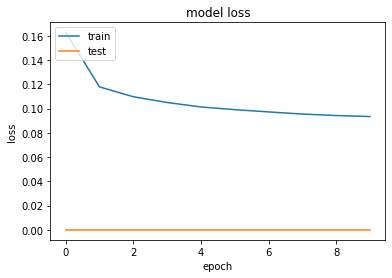

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
#4

# reference -> https://blog.keras.io/building-autoencoders-in-keras.html

# use Matplotlib (don't ask)

def show_imgs(imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

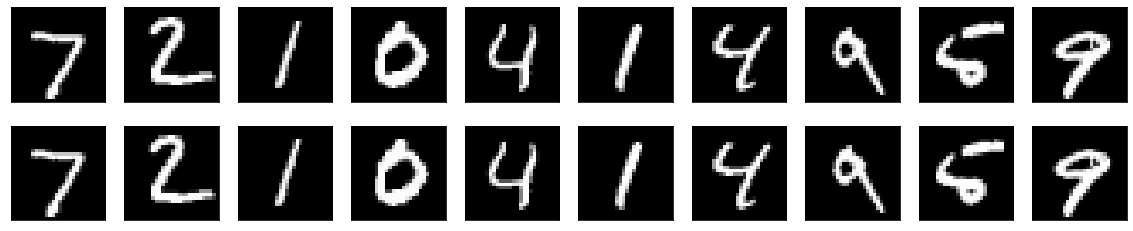

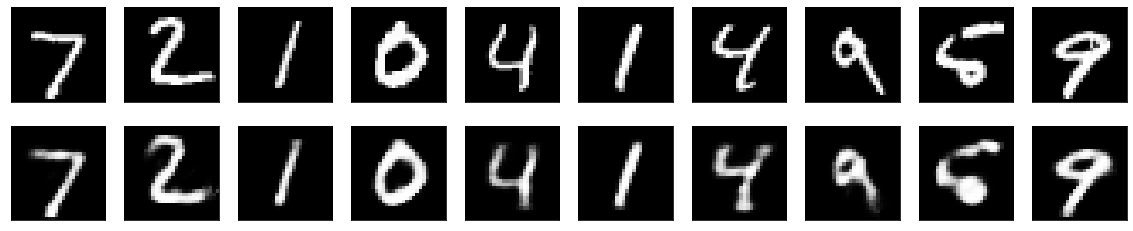

In [18]:
test = autoencoder.predict(x_test)
show_imgs(x_test)
show_imgs(test)

(array([ 18.,  31.,  64.,  97., 107., 106., 116.,  98.,  96., 115., 100.,
        113., 112.,  96., 116., 115., 112., 108., 122., 126., 141., 151.,
        140., 159., 156., 158., 152., 149., 160., 161., 173., 160., 161.,
        161., 167., 165., 166., 151., 173., 163., 156., 131., 149., 148.,
        147., 137., 144., 139., 148., 161., 124., 121., 108.,  99., 117.,
        122., 104., 105., 108.,  97., 104.,  98.,  98.,  82.,  70.,  81.,
         86.,  69.,  71.,  64.,  74.,  59.,  51.,  57.,  41.,  45.,  51.,
         44.,  48.,  36.,  27.,  39.,  40.,  38.,  31.,  37.,  32.,  31.,
         29.,  40.,  24.,  25.,  30.,  26.,  32.,  26.,  20.,  17.,  18.,
         19.,  22.,  20.,  19.,  14.,  13.,  15.,  17.,  11.,   7.,   9.,
         10.,  15.,   5.,  15.,  11.,  14.,   8.,   7.,  10.,   4.,   1.,
          7.,   7.,   9.,   7.,   4.,   5.,   6.,   2.,   4.,   5.,   6.,
          5.,   4.,   5.,   2.,   2.,   5.,   3.,   5.,   6.,   2.,   1.,
          2.,   0.,   4.,   3.,   3., 

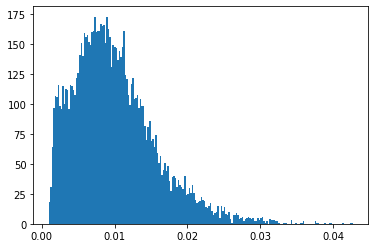

In [22]:

errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(x_test, test):
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
plt.hist(errors, bins=200)

In [11]:
thresh = np.quantile(errors, 0.99)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.02833594663068652
[INFO] 600 outliers found
